# Consistency of Atmospheric Moisture and Mass Budgets in ERA5

* find the way to compute global mass budget (dry air + moisure) on ERA5
* Apply this budget computation in AI weather prediction model as physcis-based constraints. 

In [1]:
import numpy as np
import xarray as xr

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
ds_upper = xr.open_zarr('/glade/derecho/scratch/ksha/CREDIT_data/ERA5_pressure_lev/upper_air_test.zarr')
ds_surf = xr.open_zarr('/glade/derecho/scratch/ksha/CREDIT_data/ERA5_pressure_lev/surf_test.zarr')

In [4]:
GRAVITY = 9.80665
R = 6371000  # m

In [5]:
x = ds_surf['longitude']
y = ds_surf['latitude']
lon, lat = np.meshgrid(x, y)
level_p = 100*np.array(ds_upper['level'])

In [6]:
level_p # Pa or kg/m/s2

array([   100,    200,    300,    500,    700,   1000,   2000,   3000,
         5000,   7000,  10000,  12500,  15000,  17500,  20000,  22500,
        25000,  30000,  35000,  40000,  45000,  50000,  55000,  60000,
        65000,  70000,  75000,  77500,  80000,  82500,  85000,  87500,
        90000,  92500,  95000,  97500, 100000])

In [7]:
q = np.array(ds_upper['specific_humidity']) # kg/kg
u = np.array(ds_upper['u_component_of_wind']) # m/s
v = np.array(ds_upper['v_component_of_wind'])

In [8]:
def dx_dy(lat, lon):
    # Convert latitude and longitude from degrees to radians
    lat_rad = np.radians(lat)
    lon_rad = np.radians(lon)
    
    # Calculate the grid spacings in the latitude and longitude directions
    dy = R * np.gradient(lat_rad, axis=0)
    dx = R * np.cos(lat_rad) * np.gradient(lon_rad, axis=1)

    return lat_rad, lon_rad, dy, dx
    
def Poisson_FDM(f, dx, dy, max_iterations=1000, tolerance=1e-5, omega=1.0):
    ny, nx = f.shape
    E = np.zeros((ny, nx))
    
    for iteration in range(max_iterations):
        E_new = np.copy(E)
        
        dx_avg = (dx[1:-1, 1:-1] + dx[1:-1, 2:]) / 2
        dy_avg = (dy[1:-1, 1:-1] + dy[2:, 1:-1]) / 2
        
        dy_avg2 = dy_avg**2
        dx_avg2 = dx_avg**2
        
        # Corrected denom calculation
        denom = 2/dx_avg2 + 2/dy_avg2
        
        E_new[1:-1, 1:-1] = (1 - omega) * E[1:-1, 1:-1] + omega * (
            (E[2:, 1:-1] + E[:-2, 1:-1]) / dy_avg2 +
            (E[1:-1, 2:] + E[1:-1, :-2]) / dx_avg2 -
            f[1:-1, 1:-1]
        ) / denom
        
        E_new[0, :] = E_new[-1, :] = E_new[:, 0] = E_new[:, -1] = 0
        
        if np.max(np.abs(E_new - E)) < tolerance:
            print(f'Converged after {iteration+1} iterations.')
            break
        
        E = E_new
    
    return E

def forward_laplacian(E, dx, dy):
    ny, nx = E.shape
    laplacian_E = np.zeros_like(E)
    
    for i in range(1, ny-1):
        for j in range(1, nx-1):
            dx_avg = (dx[i, j] + dx[i, j+1]) / 2
            dy_avg = (dy[i, j] + dy[i+1, j]) / 2
            
            laplacian_E[i, j] = (
                (E[i+1, j] - 2*E[i, j] + E[i-1, j]) / dy_avg**2 +
                (E[i, j+1] - 2*E[i, j] + E[i, j-1]) / dx_avg**2
            )
    
    return laplacian_E

def compute_gradient_2d(E, lat, lon):
    lat_rad, lon_rad, dy, dx = dx_dy(lat, lon)
    # Use second-order central differencing in the interior, and forward/backward at the boundaries
    dEdy = np.zeros_like(E)
    dEdx = np.zeros_like(E)
    
    # Central differencing in the interior (higher order)
    dEdy[1:-1, :] = (E[2:, :] - E[:-2, :]) / (dy[1:-1, :] + dy[:-2, :])
    dEdx[:, 1:-1] = (E[:, 2:] - E[:, :-2]) / (dx[:, 1:-1] + dx[:, :-2])

    # Forward differencing at the first row (North boundary)
    dEdy[0, :] = (E[1, :] - E[0, :]) / dy[0, :]
    # Backward differencing at the last row (South boundary)
    dEdy[-1, :] = (E[-1, :] - E[-2, :]) / dy[-1, :]

    # Forward differencing at the first column (Prime meridian)
    dEdx[:, 0] = (E[:, 1] - E[:, 0]) / dx[:, 0]
    # Backward differencing at the last column (International Date Line)
    dEdx[:, -1] = (E[:, -1] - E[:, -2]) / dx[:, -1]
    
    return dEdy, dEdx

def compute_divergence(u, v, lat, lon):
    
    lat_rad, lon_rad, dy, dx = dx_dy(lat, lon)
    
    # Compute the partial derivatives along latitude and longitude, maintaining the time dimension
    dvdy = np.gradient(v, axis=-2) / dy  # Gradient along latitude
    dudx = np.gradient(u, axis=-1) / dx  # Gradient along longitude
    
    # Total divergence
    divergence = dudx + dvdy
    
    return divergence

In [9]:
lat_rad, lon_rad, dy, dx = dx_dy(lat, lon)

## Barotropic wind field correction using the budget of mass flux

Reference:
* [Trenberth and Fasullo (2018)](https://doi.org/10.1175/JCLI-D-17-0838.1)
* [Trenberth (1991)](https://doi.org/10.1175/1520-0442(1991)004<0707:CDFGAC>2.0.CO;2)
* [ERA5 documentation](
https://confluence.ecmwf.int/display/CKB/Mass-consistent+atmospheric+energy+and+moisture+budget+data+from+1979+to+present+derived+from+ERA5+reanalysis%3A+Product+User+Guide)

Equation

\begin{equation}
\frac{1}{g}\frac{\partial}{\partial t}p_s - \frac{1}{g}\frac{\partial}{\partial t}\int_{0}^{p_s}{q}dp + \mathbf{\nabla} \cdot \frac{1}{g} \int_{0}^{p_s}{\left[\left(1-q\right)\mathbf{v}\right]}dp = 0
\end{equation}

Re-write to remove $p_s$

\begin{equation}
\mathbf{\nabla} \cdot \frac{1}{g} \int_{0}^{p_s}{\left[\left(1-q\right)\mathbf{v}\right]}dp + \frac{1}{g}\frac{\partial}{\partial t}\int_{0}^{p_s}{\left(1-q\right)}dp = 0
\end{equation}

Keep $p_s$ unchanged and close budget on $q$

\begin{equation}
\mathbf{\nabla} \cdot \frac{1}{g} \int_{p_0}^{p_1}{\left[\left(1-q\right)\mathbf{v}\right]}dp + \frac{1}{g}\frac{\partial}{\partial t}\int_{p_0}^{p_1}{\left(1-q\right)}dp = e
\end{equation}

* First term: the divergence of vertically integrated dry air mass flux
* Second term: the tendency of surface pressure due to dry air
* $e$: the residual of mass balance
* $g$: gravitational constant
* $p_s$: surface pressure
* $q$: specific humidity
* $\mathbf{v}$: horizontal wind vector

Correcting $\mathbf{v}$ based on residuals:

* Step1: find $E$ that satisfies $\nabla^2 E = e$ using a Posson eqution solver
* Compute the residual wind $\mathbf{v}_c$

\begin{equation}
\mathbf{v}_c = \mathbf{\nabla} E 
\end{equation}

* Apply barotropic wind correction:

\begin{equation}
\mathbf{v}_*\left(l, x, y\right) = \mathbf{v}\left(l, x, y\right) + g\frac{\mathbf{v}_c\left(x, y\right)}{\Delta p}
\end{equation}

* Replace $\mathbf{v}$ with $\mathbf{v}_*$ and do the correction again (iterative)

### One-step correction

In [10]:
# P_dry = np.empty((3,)+lon.shape) # kg/m/s2

# for i_time in range(3):
#     for ix in range(lon.shape[0]):
#         for iy in range(lon.shape[1]):
#             q_column = 1 - q[i_time, :, ix, iy]
#             P_dry[i_time, ix, iy] = np.trapz(q_column, level_p)
            
# P_dry = P_dry / GRAVITY # kg/m2/s
# dP_dry = (P_dry[1, ...] - P_dry[0, ...])

# Fx_dry = u*(1-q)
# Fy_dry = v*(1-q)

# Fx_dry_int = np.empty((3,)+lon.shape) # kg / s^3
# Fy_dry_int = np.empty((3,)+lon.shape)

# for i_time in range(3):
#     for ix in range(lon.shape[0]):
#         for iy in range(lon.shape[1]):
#             Fx_column = Fx_dry[i_time, :, ix, iy]
#             Fx_dry_int[i_time, ix, iy] = np.trapz(Fx_column, level_p)
            
#             Fy_column = Fy_dry[i_time, :, ix, iy]
#             Fy_dry_int[i_time, ix, iy] = np.trapz(Fy_column, level_p)

# Fx_dry_int = Fx_dry_int / GRAVITY
# Fy_dry_int = Fy_dry_int / GRAVITY

# div_mass = compute_divergence(Fx_dry_int, Fy_dry_int, lat, lon) # kg/m2/s
# residual_mass = div_mass[1, ...] + dP_dry
# Chi = Poisson_FDM(residual_mass, dx, dy, max_iterations=1000, tolerance=1e-5, omega=1.0)
# res_v, res_u = compute_gradient_2d(Chi, lat, lon)

### Iterative correction

In [35]:
t0 = 0
t1 = 1

# ??
# use the divergence of mass flux on t0 (or t1) to compare against the pressure tendency from t0 to t1
tc = t0

In [36]:
P_dry = np.empty((3,)+lon.shape) # kg/m/s2

for i_time in range(3):
    for ix in range(lon.shape[0]):
        for iy in range(lon.shape[1]):
            q_column = 1 - q[i_time, :, ix, iy]
            P_dry[i_time, ix, iy] = np.trapz(q_column, level_p)
            
P_dry = P_dry / GRAVITY # kg/m2/s
# tendency of dry air pressure
dP_dry = (P_dry[t1, ...] - P_dry[t0, ...]) / 3600 # divide by the number of seconds??

In [57]:
u_correct = np.copy(u[tc, ...])
v_correct = np.copy(v[tc, ...])

Fx_dry_int = np.empty(lon.shape) # kg / s^3
Fy_dry_int = np.empty(lon.shape)

for i in range(2):

    Fx_dry = u_correct*(1-q[tc, ...])
    Fy_dry = v_correct*(1-q[tc, ...])
    
    for ix in range(lon.shape[0]):
        for iy in range(lon.shape[1]):
            Fx_column = Fx_dry[:, ix, iy]
            Fx_dry_int[ix, iy] = np.trapz(Fx_column, level_p)
            
            Fy_column = Fy_dry[:, ix, iy]
            Fy_dry_int[ix, iy] = np.trapz(Fy_column, level_p)
    
    Fx_dry_int = Fx_dry_int / GRAVITY
    Fy_dry_int = Fy_dry_int / GRAVITY
    
    div_mass = compute_divergence(Fx_dry_int, Fy_dry_int, lat, lon) # kg/m2/s
    residual_mass = div_mass + dP_dry
    
    print('Global mean residual mass: {}'.format(np.mean(np.abs(residual_mass))))
    # ------------------------------------ #
    # Poisson solver: max_iterations=10000, tolerance=1e-5
    Chi = Poisson_FDM(residual_mass, dx, dy, max_iterations=10000, tolerance=1e-5, omega=1.0)
    # ------------------------------------ #
    res_v, res_u = compute_gradient_2d(Chi, lat, lon)
    
    u_correct = u_correct - GRAVITY * res_u/(level_p[-1] - level_p[0])
    v_correct = v_correct - GRAVITY * res_v/(level_p[-1] - level_p[0])


# ----------------------------------- #
Fx_dry = u_correct*(1-q[tc, ...])
Fy_dry = v_correct*(1-q[tc, ...])

for ix in range(lon.shape[0]):
    for iy in range(lon.shape[1]):
        Fx_column = Fx_dry[:, ix, iy]
        Fx_dry_int[ix, iy] = np.trapz(Fx_column, level_p)
        
        Fy_column = Fy_dry[:, ix, iy]
        Fy_dry_int[ix, iy] = np.trapz(Fy_column, level_p)

Fx_dry_int = Fx_dry_int / GRAVITY
Fy_dry_int = Fy_dry_int / GRAVITY

div_mass = compute_divergence(Fx_dry_int, Fy_dry_int, lat, lon) # kg/m2/s
residual_mass = div_mass + dP_dry

print('Global mean residual mass: {}'.format(np.mean(np.abs(residual_mass))))

Global mean residual mass: 0.06963765893231313
Global mean residual mass: 0.04717056318932989
Global mean residual mass: 0.04010380074744183


Text(0.5, 1.0, 'original 1000 hPa u')

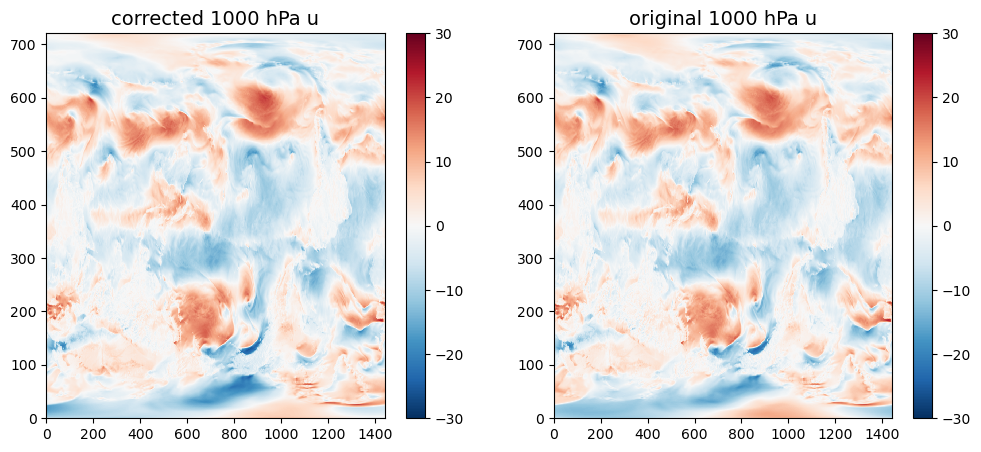

In [58]:
# Plot the original source term f and the calculated Laplacian to compare
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.pcolormesh(u_correct[-1, ...], vmin=-30, vmax=30, cmap=plt.cm.RdBu_r)
plt.colorbar()
plt.title('corrected 1000 hPa u', fontsize=14)

plt.subplot(1, 2, 2)
plt.pcolormesh(u[tc, -1, ...], vmin=-30, vmax=30, cmap=plt.cm.RdBu_r)
plt.colorbar()
plt.title('original 1000 hPa u', fontsize=14)

## Moisture budget

### The moisture budget

Reference
* [Mayer et al. (2021)](https://doi.org/10.1175/JCLI-D-20-0676.1)
* [Seager and Henderson (2013)](https://doi.org/10.1175/JCLI-D-13-00018.1)

Equation
\begin{equation}
\mathbf{\nabla} \cdot \frac{1}{g} \int_{0}^{p_s}{\left(\mathbf{v}q\right)}dp = -\frac{1}{g}\frac{\partial}{\partial t}\int_{0}^{p_s}{q}dp - E - P
\end{equation}

* $g$: gravitational constant
* $p_s$: surface pressure
* $q$: specific humidity
* $\mathbf{v}$: horizontal wind vector
* $E$ and $P$: evaporation and precipitation as flux densities. Positive from atmos to ground

### the pressure level integral of specific humidity

In [59]:
TCW_q = np.empty((3,)+lon.shape) # kg/m/s2

for i_time in range(3):
    for ix in range(lon.shape[0]):
        for iy in range(lon.shape[1]):
            q_column = q[i_time, :, ix, iy]
            TCW_q[i_time, ix, iy] = np.trapz(q_column, level_p)
            
TCW_q = TCW_q/GRAVITY # kg/m2/s

In [60]:
# TCW time diff 
TCW_test = TCW_q / 3600 #  convert to per sec
d_TCW = TCW_test[1, ...] - TCW_test[0, ...]

Text(0.5, 1.0, 'The hourly diff of q integral [kg/m2/s]')

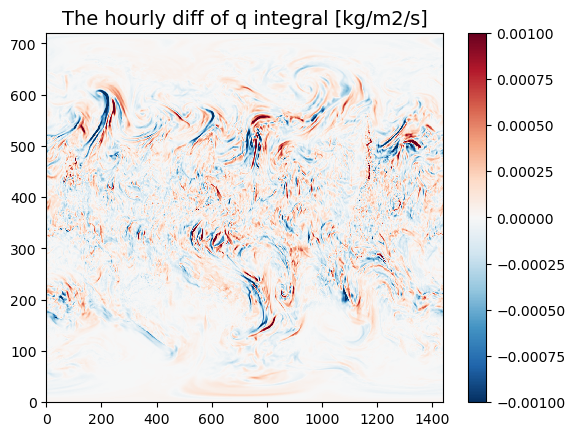

In [61]:
plt.pcolormesh(d_TCW, vmin=-1e-3, vmax=1e-3, cmap=plt.cm.RdBu_r)
plt.colorbar()
plt.title('The hourly diff of q integral [kg/m2/s]', fontsize=14)

### Evaporation and precipitation

In [62]:
precip = np.array(ds_surf['total_precipitation'])
evapor = np.array(ds_surf['evaporation'])

p_flux = precip / 3600 # m/s --> kg/m^2/s
e_flux = evapor / 3600

net_flux = -e_flux - p_flux

Text(0.5, 1.0, 'Net precip and evapor flux [kg/m2/s]')

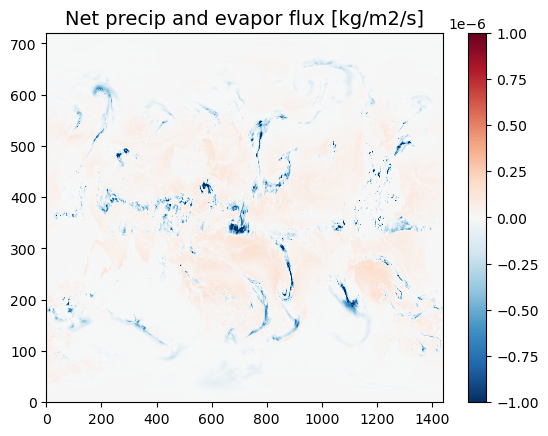

In [63]:
plt.pcolormesh(net_flux[0, ...], vmin=-1e-6, vmax=1e-6, cmap=plt.cm.RdBu_r)
plt.colorbar()
plt.title('Net precip and evapor flux [kg/m2/s]', fontsize=14)

### The divergence of vertically integrated moisture flux

In [64]:
Fx = u_correct*q[tc, ...] # m/s
Fy = v_correct*q[tc, ...]

# Fx = u[tc, ...]*q[tc, ...] # m/s
# Fy = v[tc, ...]*q[tc, ...]

In [65]:
Fx_int = np.empty(lon.shape) # kg / s^3
Fy_int = np.empty(lon.shape)

for ix in range(lon.shape[0]):
    for iy in range(lon.shape[1]):
        Fx_column = Fx[:, ix, iy]
        Fx_int[ix, iy] = np.trapz(Fx_column, level_p)
        
        Fy_column = Fy[:, ix, iy]
        Fy_int[ix, iy] = np.trapz(Fy_column, level_p)

Fx_int = Fx_int / GRAVITY # kg/m/s
Fy_int = Fy_int / GRAVITY

In [66]:
div_term = compute_divergence(Fx_int, Fy_int, lat, lon) # kg/m2/s

Text(0.5, 1.0, 'The divergence of moisture flux integral [kg/m2/s]')

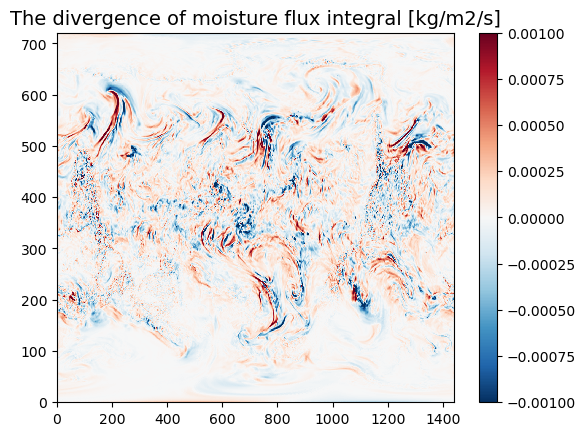

In [67]:
plt.pcolormesh(div_term, vmin=-1e-3, vmax=1e-3, cmap=plt.cm.RdBu_r)
plt.colorbar()
plt.title('The divergence of moisture flux integral [kg/m2/s]', fontsize=14)

### budget residuals

In [68]:
# pick t = 1
left_group = -div_term -e_flux[tc, ...] - p_flux[tc, ...]

# d(t=1) - d(t=0)
right_group = TCW_test[t1, ...] - TCW_test[t0, ...]

In [69]:
# no correction: 83.9847268789269
# 2 step correction: 78.88053420246573
print(np.sum(np.abs(left_group-right_group)))

78.88053420246573


Text(0.5, 1.0, 'E - P - transport vs. dTCW')

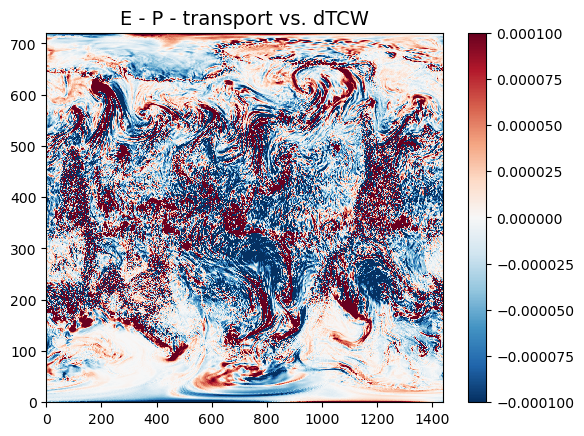

In [56]:
plt.pcolormesh(left_group-right_group, vmin=-1e-4, vmax=1e-4, cmap=plt.cm.RdBu_r)
plt.colorbar()
plt.title('E - P - transport vs. dTCW', fontsize=14)

Text(0.5, 1.0, 'E - P - transport')

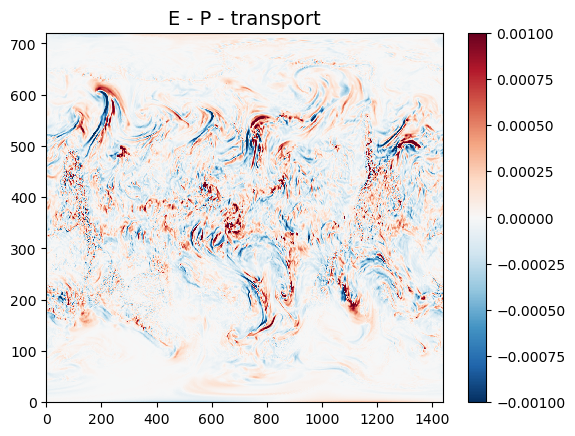

In [26]:
plt.pcolormesh(left_group, vmin=-1e-3, vmax=1e-3, cmap=plt.cm.RdBu_r)
plt.colorbar()
plt.title('E - P - transport', fontsize=14)

Text(0.5, 1.0, 'dTCW')

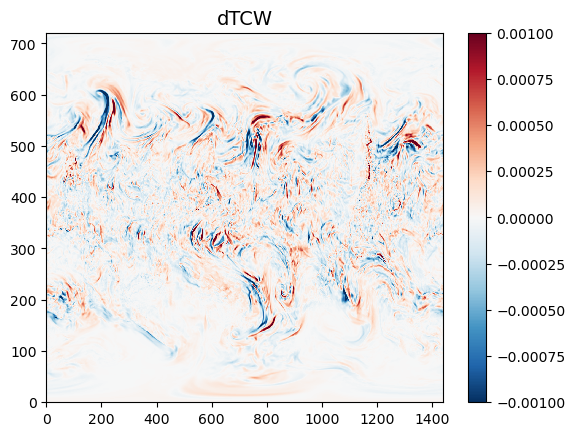

In [27]:
plt.pcolormesh(right_group, vmin=-1e-3, vmax=1e-3, cmap=plt.cm.RdBu_r)
plt.colorbar()
plt.title('dTCW', fontsize=14)

## Pytorch version (x)

In [52]:
lon_tensor = torch.from_numpy(lon)
lat_tensor = torch.from_numpy(lat)
level_tensor = torch.from_numpy(level_p)

In [22]:
q_tensor = torch.from_numpy(np.array(q))
TWC_tensor = torch.from_numpy(np.array(TWC ))